## Part b: Droplet evaporation and Contact angle measurement. (12 points)
### b1) Calibration (2 points)
We start by finding the calibration of the camera. We use a Harris corner detector to find the crossing points of the lines in our calibration image, which can then be fed into our calibration function from (a).

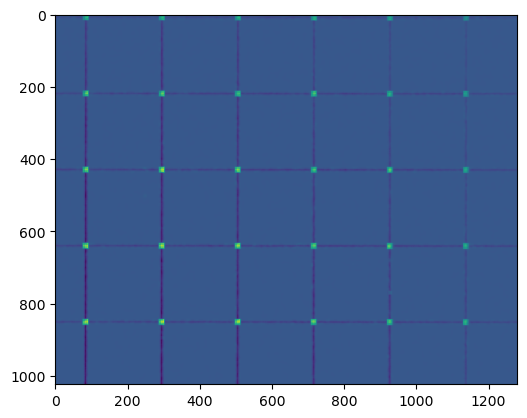

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
from scipy.optimize import curve_fit

#import the image, converted to grayscale
gray = cv.imread('Images/Calibration_b/20201204-2x-500um.tif', 0)

#find corners and plot on original image
img_corner = cv.cornerHarris(gray,10,3,0.04)
img_corner1 = np.copy(img_corner)

#to detect the corners, we have to get rid of the rest
# the image, then we can find the points using connectedComponents function
ret, thresh = cv.threshold(img_corner,0.1*img_corner.max(),255,0)
thresh = np.uint8(thresh)
ret, labels, stats, centroids = cv.connectedComponentsWithStats(thresh)
plt.imshow(img_corner)

#insert scaling function here
# so we have a scaling of...
calibration = 1 #um/px
dc = 0.1 # error in calibration

### b2) Drop Shape and Contact Angle (4 points)
Finding the drop shape takes a few steps. First we import the image, then convert it to gray-scale. We then threshold it, to get a binary-image. The contour function is then used to find the contour of the drop. We then have to do some masking of the contours to extract the drop shape. One could simply slice the image in a normal situation, but for some reason the function kept detecting the edges of the frame and drop shape as one large contour. So we would have to get rid of these via masking anyways. The height of the substrate was determined by thresholding the image and finding the height of the substrate manually.
\\
Another option which we chose not to use, is to use the final images which only show the base and subtract these from our image we want to analyse. We chose not to do this, because this did not perfectly extract the drop and we would still have to slice the contours to properly get the drop shape. Finally, because our edge detection detected the edge of the image, we still have to slice that off. So in our case masking was easier and works well. In the second set of images, we also have no base to substract, as we have no empty images. This means we would have to rewrite part of our code, which we now do not have to do.

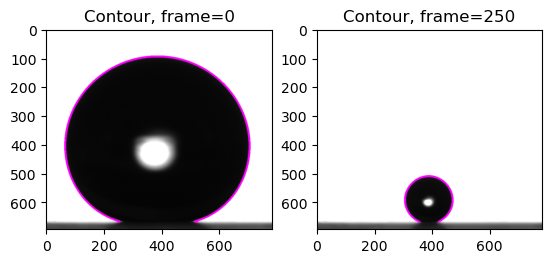

In [2]:
ysubstrate = 670
for i in range(290+1):
    num = f'{i}' #pad number to 0007 shape
    # Import the image, convert to gray
    img = cv.imread(f'Images/EvaporatingDroplet/experiment{num.zfill(4)}.tif')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    #threshold
    _,thresh = cv.threshold(gray, 125, 255, cv.THRESH_BINARY)

    #find contours
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    points = np.vstack(contours[-1]).squeeze()
    x, y = points[:,0], points[:,1]

    # taking off the edges of the frame it keeps detecting >:(, and the bottom substrate
    mask = (y != 0) & (x != 0) & (x != np.max(x)) & (y != np.max(y)) & (y<ysubstrate)
    points = points[mask]

    #reshape into a contour
    ctr = np.array(points).reshape((-1,1,2)).astype(np.int32)

    cv.drawContours(img, ctr, -1, (255,0,255), 5)
    
    if i == 0:
        f = plt.figure()
        f.add_subplot(1,2, 1)
        plt.imshow(img)
        plt.title(f'Contour, frame={i}')
    if i == 250:
        f.add_subplot(1,2, 2)
        plt.imshow(img)
        plt.title(f'Contour, frame={i}')
plt.show()

To fit the base radius, we find the contours at the height of the substrate and find the minimum and maximum values of said contour at that height. The difference between these two is $2r$. We do this up until image 275, where the drop has completely evaporated and no contours are detected anymore.

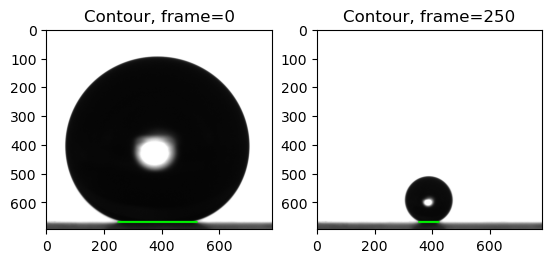

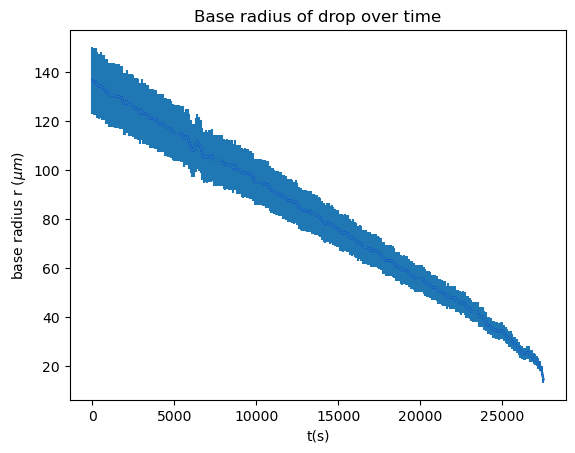

In [13]:
stop = 275
base_radius = np.zeros(stop+1)
fps = 0.01
dt = 1/fps

for i in range(stop+1):
    num = f'{i}' #pad number to 0007 shape
    # Import the image, convert to gray
    img = cv.imread(f'Images/EvaporatingDroplet/experiment{num.zfill(4)}.tif')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    #threshold
    _,thresh = cv.threshold(gray, 125, 255, cv.THRESH_BINARY)

    #find contours
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    points = np.vstack(contours[-1]).squeeze()
    x, y = points[:,0], points[:,1]
    
    # finding base radius, find points at height of substrate
    mask2 = (y != 0) & (x != 0) & (x != np.max(x)) & (y != np.max(y)) & (y==ysubstrate-1)
    xbase = x[mask2]
    x1 = np.min(xbase)
    x2 = np.max(xbase)
    
    #base radius is half of base
    base_radius[i] = abs(x1-x2)/2
    
    img = cv.line(img, (x1, ysubstrate-1), (x2, ysubstrate-1), (0,255,0), 5)
    if i == 0:
        f = plt.figure()
        f.add_subplot(1,2, 1)
        plt.imshow(img)
        plt.title(f'Contour, frame={i}')
    if i == 250:
        f.add_subplot(1,2, 2)
        plt.imshow(img)
        plt.title(f'Contour, frame={i}')
plt.show()

#error calculation
dr = np.sqrt((base_radius**2)*(dc**2))

t1 = np.linspace(0, len(base_radius)*dt-dt, len(base_radius))
plt.figure()
plt.errorbar(t1, base_radius*calibration, yerr=dr)
plt.plot(t1, base_radius*calibration, 'b')
plt.xlabel('t(s)')
plt.ylabel(r'base radius r ($\mu m$)')
plt.title('Base radius of drop over time')
plt.show()

When we fit an ellipse or circle through the whole drop, this ellipse usually does not match the drop well near the bottom. The drop is not an ellipse/circle. So for the first 250 frames, only the bottom part of the drop is fitted to the ellipse, so it fits well at the bottom. Then after 250 frames the bubble becomes rounded enough to fit the whole drop again. We then use the fitted ellipse parameters to calculate a bunch of points at and slightly above the substrate on one side, then fit a line through these points. Then we calculate the angle using this line. When the drop shrinks and has an angle of more than 90 degrees, we have to subtract the found angle from 180 degrees, because of how the angle is defined in regards to the axis.

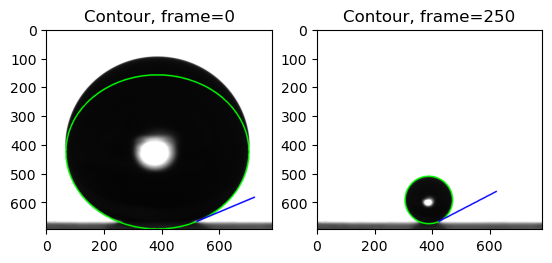

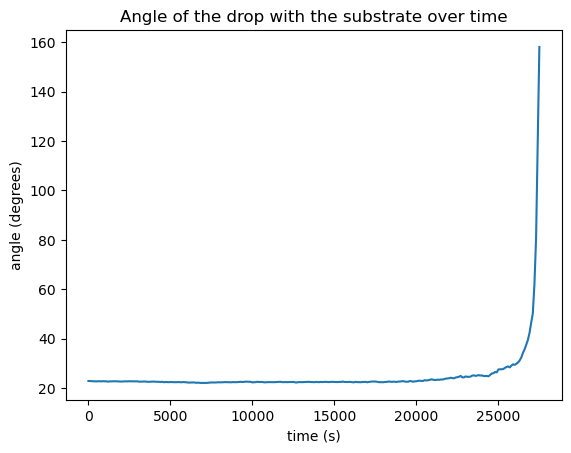

In [4]:
def func(x, a, b):
    return a*x + b


h, w = 694, 784
ysubstrate = 670

angle = np.zeros(275+1)
da = np.zeros(275+1)

for i in range(275+1):
    num = f'{i}' #pad number to 0007 shape
    # Import the image, convert to gray
    img = cv.imread(f'Images/EvaporatingDroplet/experiment{num.zfill(4)}.tif')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    #threshold
    _,thresh = cv.threshold(gray, 125, 255, cv.THRESH_BINARY)

    #find contours
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    points = np.vstack(contours[-1]).squeeze()
    x, y = points[:,0], points[:,1]

    # taking off the edges of the frame it keeps detecting >:(, and the bottom substrate
    mask = (y != 0) & (x != 0) & (x != np.max(x)) & (y != np.max(y)) & (y<ysubstrate)
    points = points[mask]

    #reshape into a contour
    ctr = np.array(points).reshape((-1,1,2)).astype(np.int32)
    
    #draw contours on image
    #cv.drawContours(img, ctr, -1, (255,0,0), 5)
    
    ## Draw 
    canvas = np.zeros_like(img)
    cv.drawContours(canvas , ctr, -1, (0, 255, 0), 1)
    
    circles = cv.HoughCircles(canvas[:,:,1],cv.HOUGH_GRADIENT,1,300,
                            param1=50,param2=10,minRadius=0, maxRadius=0)
    
    r = circles[0,0,2]
    xc = circles[0,0,0]
    yc = circles[0,0,1]
    
    #cv.circle(img,(int(round(xc)),int(round(yc))), int(round(r)), (0,0,255), 3)
    
    if i < 250:
        points = np.vstack(contours[-1]).squeeze()
        x, y = points[:,0], points[:,1]

        # taking off the edges of the frame it keeps detecting >:(, and the bottom substrate
        mask = (y != 0) & (x != 0) & (x != np.max(x)) & (y != np.max(y)) & (y<ysubstrate) & (y>yc)
        points = points[mask]
        
        #reshape into a contour
        ctr = np.array(points).reshape((-1,1,2)).astype(np.int32)
    
    # finding base radius
    mask2 = (y != 0) & (x != 0) & (x != np.max(x)) & (y != np.max(y)) & (y<ysubstrate) & (y==ysubstrate-1)
    xbase = x[mask2]
    x1 = np.min(xbase)
    x2 = np.max(xbase)
    
    ellipse = cv.fitEllipse(ctr)
    
    u=ellipse[0][0]         #x-position of the center
    v=ellipse[0][1]         #y-position of the center
    a=ellipse[1][1]/2       #radius on the x-axis
    b=ellipse[1][0]/2      #radius on the y-axis

    t = np.linspace(0, 2*np.pi, 10000)
    
    y = v+b*np.sin(t)
    x = u+a*np.cos(t)
    
    # for bonus, fit both circle and ellipse
    #cv.ellipse(img, ellipse, (255,0,0), 3)
    
    #fit line and determine angle
    mask = (y<ysubstrate) & (y>660) & (x>xc)
    y = y[mask]
    x = x[mask]
    
    popt, pcov = curve_fit(func, x, y)
    de = np.sqrt(np.diag(pcov))[0]
    
    y2 = np.round(func(x2, *popt))
    y3 = np.round(func(x2+200, *popt))
    
    angle[i] = abs(np.arctan(popt[0])*180/np.pi)
    da[i] = np.sqrt( ((1/((popt[0]**2) + 1))**2)*(de**2)  )
    if i >= 274:
        angle[i] = 180 - abs(np.arctan(popt[0])*180/np.pi)
    #print(i, angle[i])
    #draw baseradius, fitted line and ellipse on circle
    cv.ellipse(img, ellipse, (0,255,0), 3)
    img = cv.line(img, (x2, int(y2)), (x2+200, int(y3)), (0,0,255), 3)
    
    if i == 0:
        f = plt.figure()
        f.add_subplot(1,2, 1)
        plt.imshow(img)
        plt.title(f'Contour, frame={i}')
    if i == 250:
        f.add_subplot(1,2, 2)
        plt.imshow(img)
        plt.title(f'Contour, frame={i}')
plt.show()

plt.figure()
plt.errorbar(t1, angle, yerr=da)
plt.xlabel('time (s)')
plt.ylabel('angle (degrees)')
plt.title('Angle of the drop with the substrate over time')
plt.show()

### BONUS (2 points)
We now fit both a circle and an ellipse to the dropshape. The circle is fitted using a Hough transform. As we can see from the figures below, the circle (BLUE) fits well at the top, but not at the bottom. The same goes for the ellipse (GREEN), it fits well at the top, but not really at the bottom. As the drop evaporates and becomes more rounded, the circle and ellipse fit better. The better choice for fitting would be to use an ellipse, we decided to use an ellipse only fitted through the bottom half of the drop, because we are interested in the angle, so the top of the bubble is not of much interest.

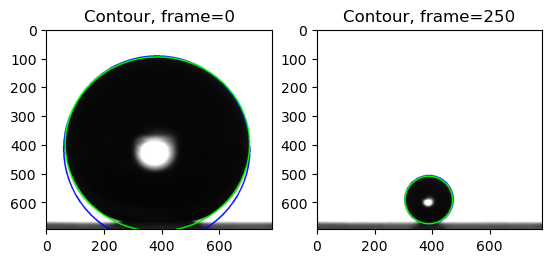

In [5]:
for i in range(275+1):
    num = f'{i}' #pad number to 0007 shape
    # Import the image, convert to gray
    img = cv.imread(f'Images/EvaporatingDroplet/experiment{num.zfill(4)}.tif')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    #threshold
    _,thresh = cv.threshold(gray, 125, 255, cv.THRESH_BINARY)

    #find contours
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    points = np.vstack(contours[-1]).squeeze()
    x, y = points[:,0], points[:,1]

    # taking off the edges of the frame it keeps detecting >:(, and the bottom substrate
    mask = (y != 0) & (x != 0) & (x != np.max(x)) & (y != np.max(y)) & (y<ysubstrate)
    points = points[mask]

    #reshape into a contour
    ctr = np.array(points).reshape((-1,1,2)).astype(np.int32)
    
    ## Draw and fit circle
    canvas = np.zeros_like(img)
    cv.drawContours(canvas , ctr, -1, (0, 255, 0), 1)
    
    circles = cv.HoughCircles(canvas[:,:,1],cv.HOUGH_GRADIENT,1,300,
                            param1=50,param2=10,minRadius=0, maxRadius=0)
    
    r = circles[0,0,2]
    xc = circles[0,0,0]
    yc = circles[0,0,1]
    
    cv.circle(img,(int(round(xc)),int(round(yc))), int(round(r)), (0,0,255), 3)
    
    # for bonus, fit both circle and ellipse
    ellipse = cv.fitEllipse(ctr)
    cv.ellipse(img, ellipse, (0,255,0), 3)
    
    if i == 0:
        f = plt.figure()
        f.add_subplot(1,2, 1)
        plt.imshow(img)
        plt.title(f'Contour, frame={i}')
    if i == 250:
        f.add_subplot(1,2, 2)
        plt.imshow(img)
        plt.title(f'Contour, frame={i}')
plt.show()

### b3) Interpretation of the plots (1 point)
At around 6000 seconds, we can see a wobble in the plotted base-radius, where the drop seems to oscillate for some reason. We can also see that the base radius goes down quite linearly, except at the end where it suddenly goes down faster. We see something similar in the angle, which goes up very slowly at first, but then around the time where the base radius shoots down, the angle shoots up. We also the angle shoot up when the drop goes from being a sphere to being being more of a dome on top of the substrate.

### b4) Drop volume (2 points)
We calculate the drop voluming by taking the formula for a solid of revolution and plugging in the contour of the drop. Instead of rotating around the x-axis, we rotate around the y-axis. We use the equation: $\pi \int x^2 dy$, where we have shifted our contour to have its center at the y-axis and only calculate for the points to the right of the y-axis, and rotate around the y-axis.


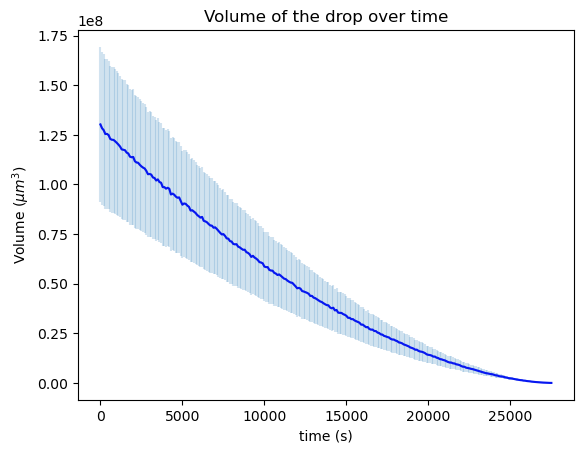

In [12]:
volume = np.zeros(275+1)

for i in range(275+1):
    num = f'{i}' #pad number to 0007 shape
    # Import the image, convert to gray
    img = cv.imread(f'Images/EvaporatingDroplet/experiment{num.zfill(4)}.tif')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    #threshold
    _,thresh = cv.threshold(gray, 125, 255, cv.THRESH_BINARY)

    #find contours
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    points = np.vstack(contours[-1]).squeeze()
    x, y = points[:,0], points[:,1]

    # taking off the edges of the frame it keeps detecting >:(, and the bottom substrate
    mask = (y != 0) & (x != 0) & (x != np.max(x)) & (y != np.max(y)) & (y<ysubstrate)
    points = points[mask]

    #reshape into a contour
    ctr = np.array(points).reshape((-1,1,2)).astype(np.int32)
    
    ## Draw and fit circle
    canvas = np.zeros_like(img)
    cv.drawContours(canvas , ctr, -1, (0, 255, 0), 1)
    
    circles = cv.HoughCircles(canvas[:,:,1],cv.HOUGH_GRADIENT,1,300,
                            param1=50,param2=10,minRadius=0, maxRadius=0)
    
    r = circles[0,0,2]
    xc = circles[0,0,0]
    yc = circles[0,0,1]
    
    #calculate volume
    x, y = x[mask], y[mask]
    mask = x > xc
    volume[i] = np.pi*np.trapz((x[mask]-xc)**2, y[mask])

#error calculation
dV = np.sqrt(   ((3*volume*(calibration**2))**2 )  *(dc**2) )

plt.figure()
plt.errorbar(t1, volume*(calibration**3), yerr=dV, alpha=0.2)
plt.plot(t1, volume*(calibration**3), 'b')
plt.xlabel('time (s)')
plt.ylabel('Volume ($\mu m^3$)')
plt.title('Volume of the drop over time')
plt.show()

### b5) Oscillating droplet (3 points)
We use two parameters for the drop, to check if both give approximately the same spectrum. We use the base radius over time and the height of the drop. We then do a fourier transform, this is the same one we used for the previous asignment. The height of the substrate has now changed too. It was determined in a similar way as before.\\
As we can see in the image below, the peak in the powerspectrum is found at 69Hz, which is is the oscillation frequency of the droplet.

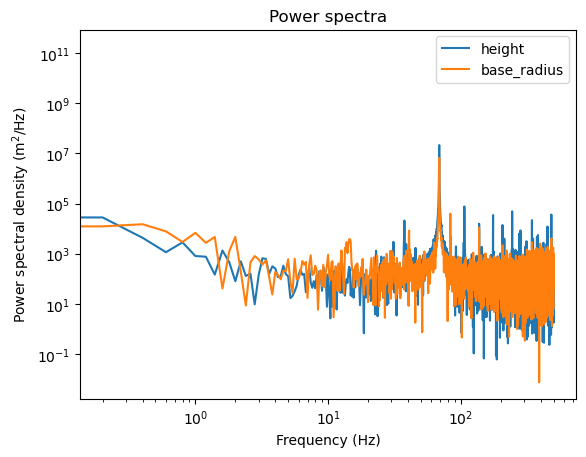

In [9]:
nN = 4999#290 #number of images
fps = 1000
dt = 1/fps
y_arr = np.zeros(nN+1)
base_radius = np.zeros(nN+1)

for i in range(nN+1):
    num = f'{i}' #pad number to 0007 shape
    img = cv.imread(f'Images/OscillatingDroplet/experiment{num.zfill(4)}.tif')
    img2 = np.copy(img)
    #turn image gray
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    #gaussian blur
    gray = cv.GaussianBlur(gray,(5,5),0)
    
    #threshold
    _,thresh = cv.threshold(gray, 125, 255, cv.THRESH_BINARY)
    
    #find contours
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    
    points = np.vstack(contours[-1]).squeeze()
    x, y = points[:,0], points[:,1]
    

    # taking off the edges of the frame it keeps detecting >:(, and the bottom substrate
    mask = (y != 0) & (x != 0) & (x != np.max(x)) & (y != np.max(y)) & (y<436)# & (y>300)
    points = points[mask]
    y_arr[i] = np.min(y[mask])
    
    # finding base radius
    mask2 = (y != 0) & (x != 0) & (x != np.max(x)) & (y != np.max(y)) & (y<436) & (y==436-1)
    xbase = x[mask2]
    x1 = np.min(xbase)
    x2 = np.max(xbase)
    base_radius[i] = abs(x1-x2)/2


def bartlett_fft(signal, fs, n_pieces):
    # Cut the signal into n equally-sized pieces
    signal_list = np.split(signal, n_pieces)
    P_list = []

    # Calculate power spectrum of each piece
    for piece in signal_list:
        P_list.append(np.abs(np.fft.fft(piece))**2)

    # Calculate the average power spectrum
    P_av = np.mean(P_list, axis=0)

    # Calculate the frequency array
    f = np.fft.fftfreq(piece.size, 1/fs)
    idx = np.argsort(f)

    # Get only positive frequencies
    f, P_av = f[idx], P_av[idx]

    return f, P_av


fs = fps # Hz
n_pieces = 1

f1, PS1 = bartlett_fft(base_radius, fs, n_pieces)
f, PS = bartlett_fft(y_arr, fs, n_pieces)
plt.figure()
plt.loglog(f, PS, '-', label='height')
plt.loglog(f1, PS1, '-', label='base_radius')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (m$^2$/Hz)')
plt.title('Power spectra')
plt.legend()
plt.show()